In [12]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
from sklearn import datasets
import math

In [13]:
import sys
sys.path.append('../code/')

In [15]:
from generate_data import make_data
from SWGG import SWGG_CP
from utils import random_slice

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


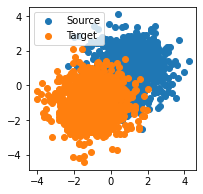

In [17]:
n=1000
dim=2
X,Y=make_data('gaussians',n,dim,device)
#X,Y=make_gaussians(n,dim=10)

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

# Exact $W^2_2$

In [18]:
ns=X.shape[0]
nt=Y.shape[0]
a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(X,Y)#,metric='euclidean')
print('W = ',ot.emd2(a,b,C))

W =  tensor(7.7967)


In [20]:
n_proj=20
theta=random_slice(n_proj,dim).T
#minS
W,_,_=SWGG_CP(X,Y,theta)
print('SWGG = ',torch.min(W))

SWGG =  tensor(9.6026)


# Evolution with $d$

In [21]:
n_seed=50

n_dim=20
max_dim=2.5#10^
dim_l = np.logspace(.4, max_dim, n_dim, dtype=int)
print('dim',dim_l)

n=50

dim [  2   3   4   5   6   8  11  14  19  24  32  41  53  68  88 114 147 190
 245 316]


In [22]:
res=torch.empty((n_seed,len(dim_l)))

In [23]:
for i in range(n_seed):
    print(i,end=' ')
    for j,d in enumerate(dim_l):
        theta=random_slice(100,d).T
        X,Y=make_data('gaussians',n,d)
        ns=X.shape[0]
        
        C=ot.dist(X,Y)
        a, b = torch.ones((ns,))/ns, torch.ones((ns,))/ns
        W=ot.emd2(a,b,C,numItermax=1000000)
        
        res[i,j]=torch.min(SWGG_CP(X,Y,theta)[0])/W
        

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [24]:
res_mean=torch.mean(res,axis=0)
res_std=torch.std(res,axis=0)
label=['Exact Wasserstein','SWGG']

In [25]:
res_mean.shape

torch.Size([20])

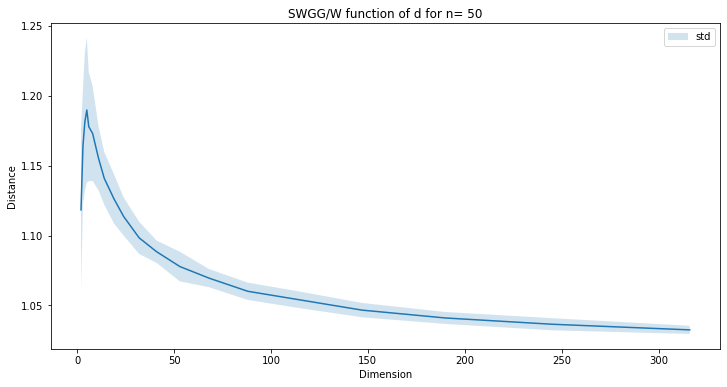

In [26]:
pl.figure(figsize=(12,6))
pl.plot(dim_l, res_mean,c='C0')
pl.fill_between(dim_l, res_mean -  2*res_std, res_mean + 2*res_std, alpha=0.2,label="std")
pl.xlabel("Dimension")
pl.ylabel("Distance")
pl.title('SWGG/W function of d for n= %i'%n)
pl.legend()
pl.show()

# Number of permutations from projections

The formula cames from: ```Cover, T. M. (1967). The number of linearly inducible orderings of points in d-space. SIAM Journal on Applied Mathematics, 15(2), 434-439.```

In [27]:
def make_Q(n,d):
    n=n-1
    Q=[n*[2]]
    for j in range(1,d):
        for i in range(0,n):
            if i==0:
                Q=Q+[[2]]
            else:
                Q[j].append(Q[j][i-1]+(i+1)*Q[j-1][i-1])
                
    Q_l=[]
    for l in range(len(Q)):
        Q_l.append(math.log(Q[l][-1]))
    return Q_l


In [28]:
n=310
dim=300
dim_l=torch.arange(1,dim+1)

In [29]:
F=math.log(math.factorial(n))

In [30]:
Q=make_Q(n,dim)

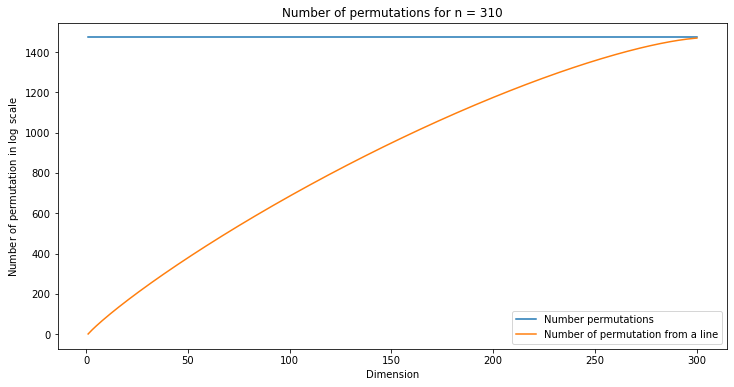

In [31]:
pl.figure(figsize=(12,6))
pl.plot(dim_l, F*torch.ones(dim_l.shape),c='C0',label='Number permutations')
pl.plot(dim_l, Q,c='C1',label='Number of permutation from a line')
pl.xlabel("Dimension")
pl.ylabel("Number of permutation in $\log$ scale")
pl.title('Number of permutations for n = %i'%n)
pl.legend()
pl.show()

# Evolution with $n$

In [48]:
n_seed=10


n_l=np.power(2,np.arange(1,13),dtype=int)
print('nb point',n_l)

dim=4

nb point [   2    4    8   16   32   64  128  256  512 1024 2048 4096]


In [49]:
res=torch.empty((n_seed,len(n_l),2))

In [50]:
for i in range(n_seed):
    print(i,end=' ')
    theta=random_slice(1000,dim).T
    for j,n in enumerate(n_l):
        X,Y=make_data('gaussians',n,dim)
        ns=X.shape[0]
        
        C=ot.dist(X,Y)
        a, b = torch.ones((ns,))/ns, torch.ones((ns,))/ns
        res[i,j,0]=ot.emd2(a,b,C,numItermax=1000000)
        
        res[i,j,1]=torch.min(SWGG_CP(X,Y,theta)[0])    
        

0 1 2 3 4 5 6 7 8 9 

In [51]:
res_mean=torch.mean(res,axis=0)
res_std=torch.std(res,axis=0)
label=['Exact Wasserstein','SWGG']

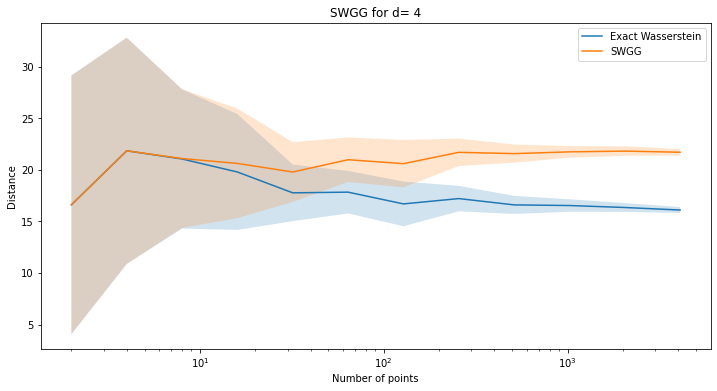

In [52]:
pl.figure(figsize=(12,6))
for i in range(len(label)):
    pl.plot(n_l, res_mean[:,i],c='C%i'%i,label=label[i])
    pl.fill_between(n_l, res_mean[:,i] -  2*res_std[:,i], res_mean[:,i] + 2*res_std[:,i], alpha=0.2)
pl.xscale('log')
pl.xlabel("Number of points")
pl.ylabel("Distance")
pl.title('SWGG for d= %i'% dim)
pl.legend()
pl.show()